# Оптимизация управления персоналом для компании "Работа с заботой"

## Описание проекта

Компания предоставила данные с характеристиками сотрудников компании. Среди них есть уровень удовлетворённости сотрудника работой. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. От этого признака напрямую влияет на отток сотрудников. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. Компания большая, поэтому с данной задачей обратились к HR-аналитикам

## Описание данных

Для этой задачи заказчик предоставил одну таблицу:
- id — уникальный идентификатор сотрудника
- dept — отдел, в котором работает сотрудник
- level — уровень занимаемой должности
- workload — уровень загруженности сотрудника
- employment_years — длительность работы в компании (в годах)
- last_year_promo — показывает, было ли повышение за последний год
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель
- salary — ежемесячная зарплата сотрудника
- *job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак*

Загрузка данных будет осуществляться через:
- тренировочную выборку
- входные признаки тестовой выборки
- целевой признак тестовой выборки

## Задача проекта

У нас есть пару задач:  
Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.  
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании

## Установка и импорт библиотек

In [1]:
!pip install pandas
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install matplotlib
!pip install phik
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import resources, report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # отключение предупреждений
from sklearn.model_selection import train_test_split
# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# создание метрики
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score

## Используемые функции

In [3]:
# Вывод различной информации о таблице
def analiz(df, dubli):
    df.info()
    print()
    display(df.describe())
    print()
    print('Кол-во пропусков в таблице')
    display(df.isna().sum())
    print()
    print('Кол-во дубликатов в таблице')
    display(df.duplicated().sum())
    print()
    print('Проверка на неявные дубликаты')
    if len(dubli) == 0:
        print('Нечего проверять')
    for i in dubli:
        print(i, df[i].unique())
    print()
    print()



# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df




# Функция для построения гистограмм и ящиков с усами для каждого признака
def numbers_plot(df, param_hue):
    sns.set(font_scale=1.2)
    numerical_columns = df.select_dtypes(include='number').drop('id', axis=1).columns
    fig, axs = plt.subplots(len(numerical_columns), 2, figsize=(11, 14))
    
    for i in range(len(numerical_columns)):
        column = numerical_columns[i]
        if column in ['employment_years', 'supervisor_evaluation']:
            sns.countplot(data = df, x = column, ax = axs[i, 0])
            axs[i, 0].set_title(column)
        else:
            sns.histplot(data = df, x = column, hue=param_hue, ax = axs[i, 0], stat='density', common_norm=False)
            axs[i, 0].set_title(column)
        
        sns.boxplot(x = df[column], ax = axs[i, 1])
        axs[i, 1].set_title(column)
    
    plt.tight_layout()
    plt.show()




# Изображает категориальные признаки в виде столбчатых диаграмм
def kategory_col(df, columns):
    sns.set(style='whitegrid')
    sns.set_palette('pastel')
    for column in columns: 
        plt.figure(figsize=(4, 4))
        df[column].value_counts().plot(kind='pie', autopct='%1.0f%%')
        plt.title(column)
        plt.show()




# Создание метрики
def smape(fact, pred):
    chislitel = np.abs(fact - pred)
    znamenatel = (np.abs(fact) + np.abs(pred)) / 2
    metric = (100 / len(fact)) * (np.sum(chislitel / znamenatel))
    return metric




# При передаче трех датафреймов находит лучшую модель и считает метрику
def best_model(ohe_column, ord_column, num_column, categorie):
    # Записываем постоянные
    RANDOM_STATE = 42
    TEST_SIZE = 0.25
    # Делим выборки
    X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis = 1)
    y_train = train_job_satisfaction_rate['job_satisfaction_rate']
    X_test = test_features
    y_test = test_target_job_satisfaction_rate
    y_test = pd.Series(y_test['job_satisfaction_rate'], name='job_satisfaction_rate')
    # Проверка
    display(X_train.shape)
    display(y_train.shape)
    display(X_test.shape)
    display(y_test.shape)
    # Столбцы для кодирований
    ohe_columns = ohe_column
    ord_columns = ord_column
    num_columns = num_column
    
    
    
    # Подготовка признаков
    # Пропуски есть только в столбцах dept и level. Они находятся в OHE и OE
    # SimpleImputer + OHE
    ohe_pipe = Pipeline(
        [('simpleImputer_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
         ('ohe', OneHotEncoder(drop = 'first', handle_unknown='ignore'))]
    )

    # SimpleImputer + OE
    ord_pipe = Pipeline(
            [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy='most_frequent')),
         ('ord',  OrdinalEncoder(
                    categories=categorie, 
                    handle_unknown = 'use_encoded_value', unknown_value = np.nan
                )
            ),
         ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ]
    )
    
    # Делаем общий пайплайн подготовки данных
    data_preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
         ('ord', ord_pipe, ord_columns),
         ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )
    
    # Модель + подготовка данных
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ])

    param_grid = [
        # Модель LinearRegression()
        {
            'models': [LinearRegression()],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
        },
            # Модель DecisionTreeRegressor()
        {
            'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
            'models__max_depth': range(5, 20), # глубина дерева
            #'models__max_leaf_nodes': range(10, 50), # отвечает за ограничение кол-ва листьев
            #'models__min_samples_split': range(5, 30), # сколько значений должно быть для того, чтобы узел м.б. разделить
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
        },
              # Модель KNeighborsClassifier() 
        {
            'models': [KNeighborsRegressor()],
            'models__n_neighbors': range(2, 10), # кол-во соседей
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
        }
    ]
    
    scorer_smape = make_scorer(smape, greater_is_better=False)
    
    # RandomizedSearchCV: инициализация и обучение 
    randomized_search = RandomizedSearchCV( 
     pipe_final,  
     param_grid,  
     cv=5, 
     scoring=scorer_smape , 
     random_state=RANDOM_STATE, 
     n_jobs=-1,  
    )
    
    return randomized_search, X_train, X_test, y_train, y_test

Посмотрим на содержимое в файлах

In [4]:
try:
    # Тренировочная выборка:
    train_job_satisfaction_rate = pd.read_csv('train_job_satisfaction_rate.csv')
    display(train_job_satisfaction_rate.head())
    # Входные признаки тестовой выборки:
    test_features = pd.read_csv('test_features.csv')
    display(test_features.head())
    # Целевой признак тестовой выборки:
    test_target_job_satisfaction_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
    display(test_target_job_satisfaction_rate.head())
except:
    # Тренировочная выборка:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    display(train_job_satisfaction_rate.head())
    # Входные признаки тестовой выборки:
    test_features = pd.read_csv('/datasets/test_features.csv')
    display(test_features.head())
    # Целевой признак тестовой выборки:
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    display(test_target_job_satisfaction_rate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


На первый взгляд все выглядит хорошо. Все не целые числа записаны через точку, столбцы на английском и вместо пробелов используется "_".  По всей видимости в столбцах last_year_promo, last_year_violations есть только no и yes, поэтому можно будет сделать тип этих столбцов bool. Нужно обратить вниамние на то, что id  в столбце test_target_job_satisfaction_rate идут не в том же порядке, как в test_features, хотя это тестовые данные

## Предобработка данных

Сразу же начнем с сортировки столбцов id в двух последних таблицах, иначе наша будущая модель на тестовых выборках покажет плохие результаты

In [5]:
test_features = test_features.sort_values(by = 'id')
display(test_features.head())
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.sort_values(by = 'id')
display(test_target_job_satisfaction_rate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


Начнем с оптимизации нашией информации с помощью функции def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:. Она проверяет минимальное и максимальное значения в столбце. Если значения могут уместиться в типе данных меньшего размера (например, np.int8 вместо np.int16), столбец конвертируется в более компактный тип данных. И для оценки стоило всё это начинать, подсчитывается размер занимаемой памяти DataFrame до и после оптимизации и выводит разницу в процентах

In [6]:
print('Для таблицы: train_job_satisfaction_rate')
display(optimize_memory_usage(train_job_satisfaction_rate))
print()
print('Для таблицы: test_features')
display(optimize_memory_usage(test_features))
print()
print('Для таблицы: test_target_job_satisfaction_rate')
display(optimize_memory_usage(test_target_job_satisfaction_rate))

Для таблицы: train_job_satisfaction_rate
Размер использования памяти: до  0.31 Mb - после  0.21 Mb (32.5%)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48



Для таблицы: test_features
Размер использования памяти: до  0.15 Mb - после  0.11 Mb (27.5%)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000
...,...,...,...,...,...,...,...,...,...
1925,997290,sales,sinior,medium,7,no,no,4,58800
1886,998548,marketing,junior,medium,2,no,no,4,32400
506,998762,technology,junior,low,3,no,no,3,22800
1579,998900,marketing,middle,medium,7,no,no,3,45600



Для таблицы: test_target_job_satisfaction_rate
Размер использования памяти: до  0.05 Mb - после  0.03 Mb (33.3%)


,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69
...,...,...
1026,997290,0.79
1613,998548,0.76
780,998762,0.48
931,998900,0.57


Теперь можно использовать функцию, которая будет  выводить информацию о столбцах таблицы, общие данные для каждого признака,  кол-во пропусков, дубликатов, уникальные значения столбцов, которые мы захотим посмотреть, чтобы избежать неявные дубликаты

In [7]:
print('Таблица train_job_satisfaction_rate')
print()
dubli_train_job_satisfaction_rate = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
analiz(train_job_satisfaction_rate, dubli_train_job_satisfaction_rate)
print('Теперь информация про таблицу test_features')
print()
dubli_test_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
analiz(test_features, dubli_test_features)
print('И последняя таблица test_features')
print()
dubli_test_target_job_satisfaction_rate = []
analiz(test_target_job_satisfaction_rate, dubli_test_target_job_satisfaction_rate)

Таблица train_job_satisfaction_rate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int32  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int8   
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int8   
 8   salary                 4000 non-null   int32  
 9   job_satisfaction_rate  4000 non-null   float32
dtypes: float32(1), int32(2), int8(2), object(5)
memory usage: 211.1+ KB



,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



Кол-во пропусков в таблице


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Теперь информация про таблицу test_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int32 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int8  
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int8  
 8   salary                 2000 non-null   int32 
dtypes: int32(2), int8(2), object(5)
memory usage: 113.

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Кол-во пропусков в таблице


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['low' 'high' 'medium' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


И последняя таблица test_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1734 to 334
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int32  
 1   job_satisfaction_rate  2000 non-null   float32
dtypes: float32(1), int32(1)
memory usage: 31.2 KB



,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000



Кол-во пропусков в таблице


id                       0
job_satisfaction_rate    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
Нечего проверять




Начнем по порядку. Изменим некоторые типы столбцов
- train_job_satisfaction_rate Поменяем тип у last_year_promo, last_year_violations с object на bool
- test_features Поменяем тип у last_year_promo, last_year_violations с object на bool

Отлично! С типами столбцов разобрались

Теперь посмотрим на таблицу с различными показателями. Особых выделяющихся значений минимумов и максимумов нет, но и это не так сейчас важно, т.к. мы к этому еще вернемся. Лучше проверим строку со средними значениями:
- mean	544957.621000	3.718500	3.476500	33926.700000	0.533995
- mean	552765.213500	3.666500	3.526500	34066.800000
- mean	552765.213500	0.54878

Все значения +- совпадают. Это означает, что тестовые и тренировочные выборки нормальные  

В таблице имеются пропуски, но их мы заполним в пайплайне

Дубликатов не имеется

При проверке на неявные дубликаты в test_features были замечены ' ', а не nan в столбцах dept и workload. Исправим это

In [10]:
test_features[['dept', 'workload']] = test_features[['dept', 'workload']].replace(' ', np.nan)

На данном шаге мы изменили типы данных у большинства столбцов для удобства и быстроты работы. Сравнили тренировочные и тестовые выборки, проверили пропуски и дубликаты(явные и неявные). Пропуски решили исправить потом в пайплайне, а из дубликатов оказались только неявные(пробелы вместо некоторых пропусков). Все это было исправлено

## Исследовательский анализ данных

Перейдем к визуальному представлению данных. Через гистограммы и ящики с усами. В этом нам поможет функция numbers_plot

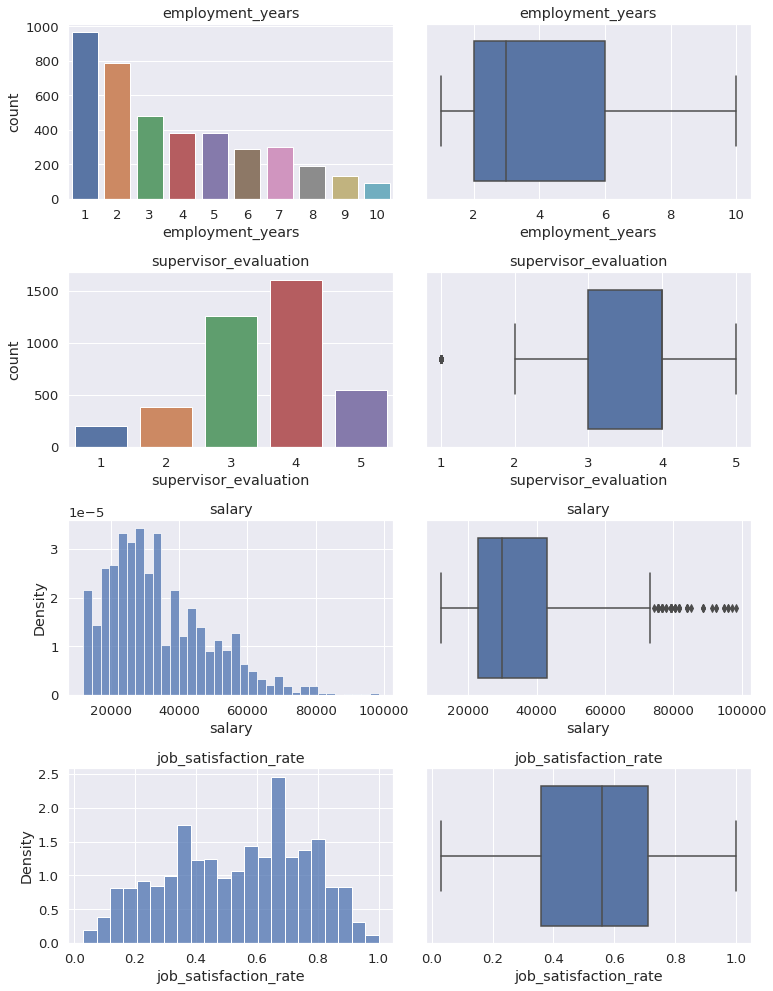

In [11]:
numbers_plot(train_job_satisfaction_rate, param_hue=None)

Желтая линиия в гистограммах показывает долю людей, которые за последний год получали повышение. Можно заметить, что работой таких сотрудников удовлетворен работодатель, как и сами сотрудники. У них зарплата выше среднего, как и длительность работы  
Чтобы получить максимально хорошие результаты модели, нам нужно у таких признаков, как оценка качества работы сотрудника и ежемесячная зарплата убрать выбросы

In [12]:
before = len(train_job_satisfaction_rate)

In [13]:
train_job_satisfaction_rate = train_job_satisfaction_rate[train_job_satisfaction_rate['supervisor_evaluation'] > 1]
train_job_satisfaction_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
...,...,...,...,...,...,...,...,...,...,...
3994,855240,sales,junior,medium,2,no,no,3,20400,0.27
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76


In [14]:
train_job_satisfaction_rate = train_job_satisfaction_rate[train_job_satisfaction_rate['salary'] < 73000]
train_job_satisfaction_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
...,...,...,...,...,...,...,...,...,...,...
3994,855240,sales,junior,medium,2,no,no,3,20400,0.27
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76


In [15]:
after = len(train_job_satisfaction_rate) 

In [16]:
100 * (before - after) / before

6.575

В итоге мы удалили чуть меньше 7% данных

Ну и конечно же проверим категориальные признаки с помощью функции kategory_col

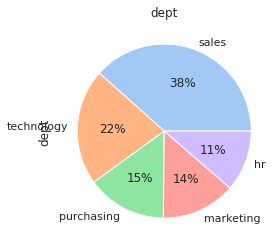

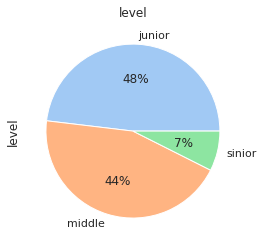

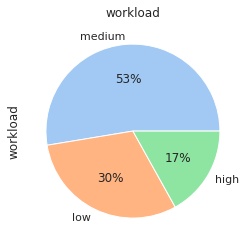

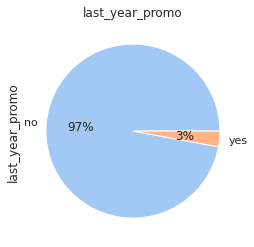

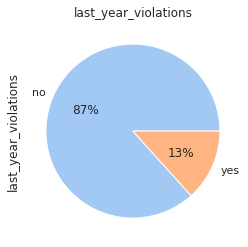

In [17]:
kat_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
kategory_col(train_job_satisfaction_rate, kat_col)

В dept больше всего работников sales. По уровню работы джунов и мидлов примерно одинаково, а сеньеров значительно меньше. Средняя загруженность составляет большую часть, потом идет низкая и тяжелая. На графике признака last_year_promo 97% сотрудников остались без повышения, а уlast_year_violations - всего 13% совершали нарушение трудового договора за последний год

Теперь посмотрим на тестовые данные

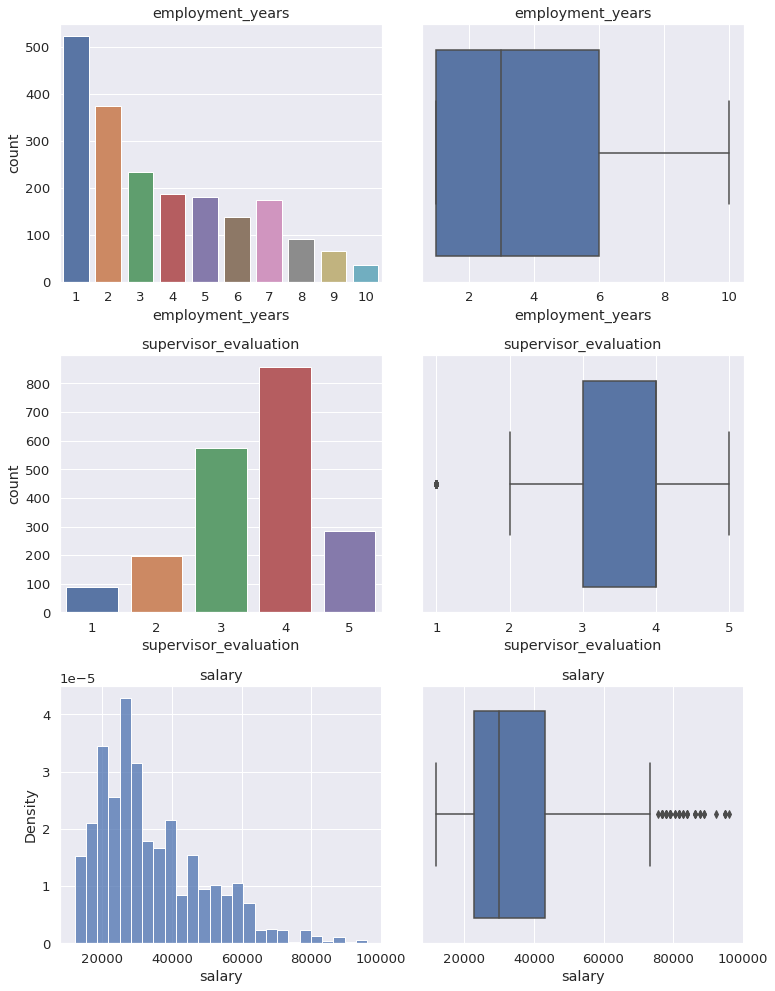

In [18]:
numbers_plot(test_features, param_hue=None)

Тут те же выбросы, что и в тренировочных данных. Их удалять нельзя, т.к это уже тестовая выборка

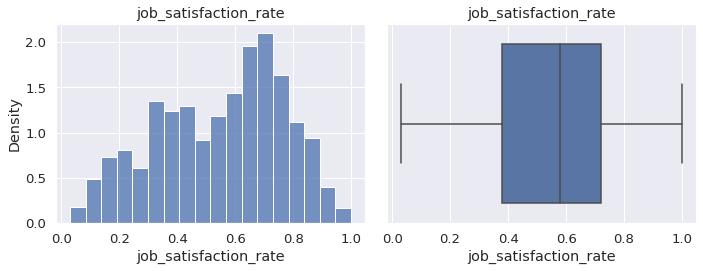

In [19]:
sns.set(font_scale=1.2)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(data=test_target_job_satisfaction_rate, x='job_satisfaction_rate', ax=ax[0], stat='density', common_norm=False)
ax[0].set_title('job_satisfaction_rate')

sns.boxplot(x=test_target_job_satisfaction_rate['job_satisfaction_rate'], ax=ax[1])
ax[1].set_title('job_satisfaction_rate')

plt.tight_layout()
plt.show()


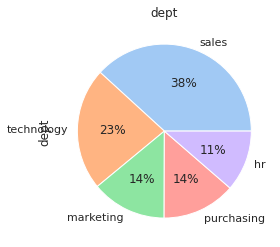

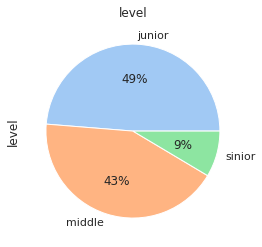

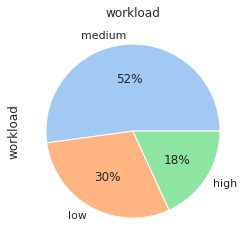

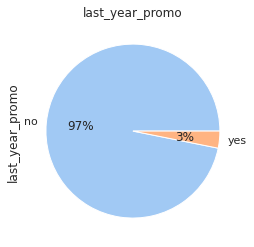

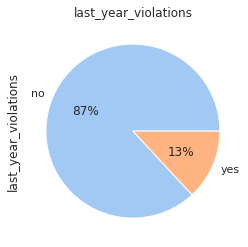

In [20]:
kat_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
kategory_col(test_features, kat_col)

В dept больше всего работников sales - 38%. По уровню работы джунов и мидлов примерно одинаково, а сеньеров значительно меньше. Средняя загруженность составляет большую часть, потом идет низкая и тяжелая. На графике признака last_year_promo 97% сотрудников остались без повышения, а у уlast_year_violations - всего 13% совершали нарушение трудового договора за последний год

После всех этих действий можно подвести небольшой итог. С помощью четырех функций: def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame, def analiz(df, dubli), def numbers_plot(df), def kategory_col(df, columns) мы сделали большую часть обработки данных
- def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame  сделала оптимизацию наших данных для быстрой работы
- def analiz(df, dubli) помогла разобраться с типами данных, где мы исправили столбцы last_year_promo, 
last_year_violationвс типа object  на тип boo. Убедились, что тестовые и тренировочные выборки сбалансированы так сказать. Нашлось несколько пропусков в отличие от дубликатов, про которые не стоит забывать. Из неявных дубликатов оказались пропуски, как пробелы вместо nan
- def numbers_plot(df) и def kategory_col(df, columns) пришлось удалить чуть меньше 7% выбросов в тренировочной выборке для лучшего качества работы модели

### Корреляционный анализ

Нужно проверить наши данные на то, как они между собой связаны, так как от этого зависит качество нашей линейной модели. Начнем со скатер плотов. Проверим зависимости каждого числового признака от целевого

Корреляция 0.2055849839069853


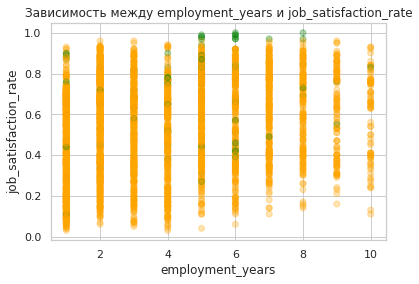

Корреляция 0.70304497899355


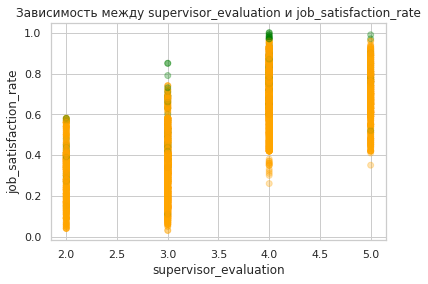

Корреляция 0.11868503122429237


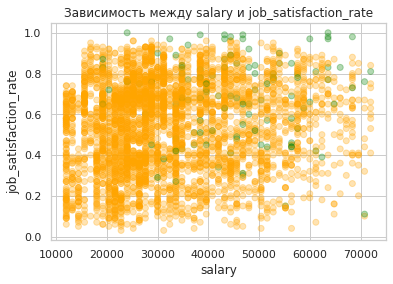

In [21]:
numerical_columns = train_job_satisfaction_rate.select_dtypes(include='number').drop(['id', 'job_satisfaction_rate'], axis=1).columns
for i in numerical_columns:
    print("Корреляция", train_job_satisfaction_rate[i].corr(train_job_satisfaction_rate['job_satisfaction_rate']))
    plt.scatter(train_job_satisfaction_rate[i], train_job_satisfaction_rate['job_satisfaction_rate'], alpha=0.3, c = train_job_satisfaction_rate['last_year_promo'].map({'no': 'orange', 'yes': 'green'}))
    plt.xlabel(i)
    plt.ylabel('job_satisfaction_rate')
    plt.title(f'Зависимость между {i} и job_satisfaction_rate')
    plt.show()

На первом графике очень слабая зависимость.  
У supervisor_evaluation от job_satisfaction_rate корреляция составляет 0.7, что подтверждает график. Можно обратить внимание на горизонтальной оси значения 2 и 3 практически совпадают по высоте, а 4, 5 на одном уровне друг с другом, но отличаются от первых трех. Можно будет попробовать преобразовать признак supervisor_evaluation в категориальный.  
В последнем графике корреляции нет, поэтому и зависимости тоже.  
Все выводы можно будет проверить с помощью матриц коррелиций

Давайте теперь посмотрим на значения корреляций меджу всеми нашими признаками

In [22]:
train_job_satisfaction_rate.drop(['id'], axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.032334,0.049185,0.000000,0.000000,0.051184,0.280124,0.096049
level,0.000000,1.000000,0.396272,0.684269,0.100947,0.000000,0.000000,0.664511,0.082802
workload,0.032334,0.396272,1.000000,0.161681,0.054212,0.000000,0.032255,0.744247,0.070556
employment_years,0.049185,0.684269,0.161681,1.000000,0.197860,0.027880,0.000000,0.477517,0.328900
last_year_promo,0.000000,0.100947,0.054212,0.197860,1.000000,0.000000,0.010307,0.197842,0.192792
last_year_violations,0.000000,0.000000,0.000000,0.027880,0.000000,1.000000,0.332012,0.000000,0.553499
supervisor_evaluation,0.051184,0.000000,0.032255,0.000000,0.010307,0.332012,1.000000,0.070291,0.680280
salary,0.280124,0.664511,0.744247,0.477517,0.197842,0.000000,0.070291,1.000000,0.172295
job_satisfaction_rate,0.096049,0.082802,0.070556,0.328900,0.192792,0.553499,0.680280,0.172295,1.000000


Проанализирем сначала последнюю строку, т.к. job_satisfaction_rate это целевой признак. employment_years	last_year_promo	last_year_violations	supervisor_evaluation	данные столбцы показали неплохую корреляцию, начиная с 0.33 и заканчивая 0.77. Эти признаки будут оказывать большее влияние на итоговую метрику.  
Посмотрим на входные признаки:  
- dept. Сильно не коррелирует с остальными признаками, поэтому мультиколлинеарности не вызывает.
- level. Есть достаточно большая связь с двумя очень важными employment_years и salary около 0.67. Этого не должно хватить для создания мультиколлинеарности, но все же возьмем на заметку, т.к. с целевым признаком особой взаимосвязи у него нет(около 0.2)
- workload. Достаточно сильно коррелирует с salary с показателем 0.74, а с job_satisfaction_rate - нет, всего 0.16. Тоже стоит запомнить
- employment_years. Про него уже есть вся информация выше.
- last_year_promo. Ни с кем их входных признаком сильно не связан. 
- last_year_violations. Такая же ситуация, как и с last_year_promo
- supervisor_evaluation. Тоже ни с кем не сильно не связан, кроме целевого признака.
- salary. Есть связь с level(0.67) и с workload(0.74). Это достаточно высокие показатели. А с job_satisfaction_rate корреляция всего - 0.12, поэтому можно будет попробовать удалить этот признак.

На данном этапе мы провели исследовательский анализ. Явной мультиколлинеарности не было замечено. С целевым признаком больше всего взаимодействуют четыре признака: employment_years last_year_promo last_year_violations supervisor_evaluation. Остальные признаки не так сильно коррелируют с  job_satisfaction_rate, а с некоторыми важными у них есть достаточно сильная связь, которая может вызвать мультиколинеарность. Возможно, прийдется какие-то из них удалить, чтобы улучшить качество модели. И еще, нужно будет проверить модель с переводом столбца supervisor_evaluation в категориальный признак

## Создание пайплайна

Подготовим пайплайн для обучения. Будем использовать для категориальных признаков два кодировщика: OneHotEncoder и OrdinalEncoder(будем применять к тем признакам, у которых зависимость значений важна). Пропуски будем заполнять с помощью SimpleImputer. Используемые модели: линейной регрессии, дерево решений и KNN

In [23]:
# Для начала переведем во всех таблицах id в индексы
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id')
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')

После удаления столбца id, нужно еще раз проверить только тренировочные данные на уникальность, то есть на выбросы.

In [24]:
train_job_satisfaction_rate.duplicated().sum()

242

In [25]:
# удалим их
train_job_satisfaction_rate.drop_duplicates()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20
405448,hr,middle,low,7,no,no,4,30000,0.78
...,...,...,...,...,...,...,...,...,...
895642,purchasing,junior,medium,2,no,no,2,25200,0.47
854006,hr,middle,medium,4,no,no,3,45600,0.47
855240,sales,junior,medium,2,no,no,3,20400,0.27


С помощью уникальных значений зполним список categories в OrdinalEncoder

In [26]:
print(train_job_satisfaction_rate['level'].unique())
print(train_job_satisfaction_rate['workload'].unique())
print(train_job_satisfaction_rate['supervisor_evaluation'].unique())
print(train_job_satisfaction_rate['employment_years'].unique())

['junior' 'middle' 'sinior' nan]
['high' 'low' 'medium']
[5 2 3 4]
[ 2  1  4  7  9  6  3 10  8  5]


Чтобы не загромождать проект создадим функцию best_model, которой будем передавать три наших датафрейма

In [27]:
ohe_column = ['dept', 'last_year_promo', 'last_year_violations']
ord_column = ['level', 'workload']

In [28]:
num_column = ['salary']
categorie = [['junior', 'middle', 'sinior'], ['medium', 'low', 'high'],] 

randomized_search, X_train, X_test, y_train, y_test = best_model(ohe_column, ord_column, num_column, categorie)
randomized_search_1 = randomized_search
randomized_search_1.fit(X_train, y_train) 
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)  
print('Лучшее значение метрики на тренировочной выборке SMAPE :\n\n', randomized_search_1.best_score_ * (-1)) 
print('Лучшие параметры модели :\n\n', randomized_search_1.best_params_)

(3737, 8)

(3737,)

(2000, 8)

(2000,)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

Получилась такая модель. С помощью проверки переборов различных гиперпараметров, как 'models__max_leaf_nodes', 'models__min_samples_split'. С ними модель оказалась хуже, т.к. данные параметры отвечают за то, чтобы не дать модели переобучиться. Больше нечего улучшать в самом пайплайне. Нужно возвращаться к предобработке или анализу данных и что-то менять, поэтому сначала попробуем поменять признак supervisor_evaluation на категориальный, который вызвал у нас подозрения в корреляционном анализе

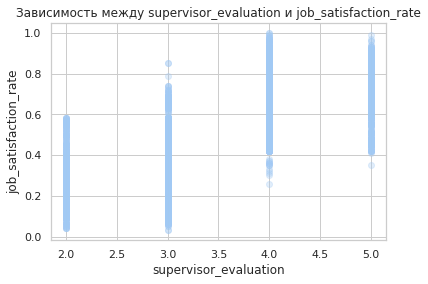

In [30]:
plt.scatter(train_job_satisfaction_rate['supervisor_evaluation'], train_job_satisfaction_rate['job_satisfaction_rate'], alpha=0.3)
plt.xlabel('supervisor_evaluation')
plt.ylabel('job_satisfaction_rate')
plt.title('Зависимость между supervisor_evaluation и job_satisfaction_rate')
plt.show()

In [31]:
train_job_satisfaction_rate.loc[train_job_satisfaction_rate['supervisor_evaluation'] < 3.5, 'supervisor_evaluation'] = 0
train_job_satisfaction_rate.loc[train_job_satisfaction_rate['supervisor_evaluation'] > 3.5, 'supervisor_evaluation'] = 1

test_features.loc[test_features['supervisor_evaluation'] < 3.5, 'supervisor_evaluation'] = 0
test_features.loc[test_features['supervisor_evaluation'] > 3.5, 'supervisor_evaluation'] = 1

Теперь можно попробовать обучить модель еще раз

In [32]:
ohe_column = ['dept', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
ord_column = ['level', 'workload']
num_column = ['salary']
categorie = [['junior', 'middle', 'sinior'], ['medium', 'low', 'high'],]
randomized_search, X_train, X_test, y_train, y_test = best_model(ohe_column, ord_column, num_column, categorie)
randomized_search_2 = randomized_search

randomized_search_2.fit(X_train, y_train) 
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)  
print('Лучшее значение метрики на тренировочной выборке SMAPE :\n\n', randomized_search_2.best_score_ * (-1)) 
print('Лучшие параметры модели :\n\n', randomized_search_2.best_params_)

pred = randomized_search_2.predict(X_test) 
test_score = smape(y_test, pred)  # Расчет и вывод метрики на тестовой выборке
print(f"Метрика на тестовой выборке: {test_score}")

(3737, 8)

(3737,)

(2000, 8)

(2000,)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'supervisor_evaluation']),
                                                 ('ord',
                                                  Pipe

Итоговая метрика на тестовой выборке для нашей наилучшей модели получилась 14.48 %. Первый раз она была 14.98 %

Из наших трех моделей лучшей оказалась DecisionTreeRegressor, благодаря своей способности выбирать наиболее важные признаки для прогнозирования. Еще она может обрабатывать нелинейные зависимости между признаками и целевой переменной. Возможно эти свойства помогли дереву решений стать лучшей моделью

На данном шаге мы создали пайплайн, который кодирует категориальные признаки с помощью двух кодировщиков: OneHotEncoder и OrdinalEncoder, а числовые - StandardScaler(), MinMaxScaler. Категориальные признаки еще предобрабатываются с помощью SimpleImputer, который заполняет пропуски популярными значениями. В пайплайне есть три модели с различными параметрами: DecisionTreeRegressor, LinearRegression, KNeighborsClassifier. С помощью RandomizedSearchCV перебираются модели и из них выбирается лучшая. Это оказалась модель DecisionTreeRegressor(random_state=42) с такими параметрами: 'preprocessor__num': MinMaxScaler(), 'models__max_depth': 15. Метрика на тренировочной выборке SMAPE - 14.3, а на тестовой - 14.48. Отличный результат! Можно идти дальше.

# Задача 2: предсказание увольнения сотрудника из компании

Вспомним задачу: нам нужно создать модель, которая будет предсказывать увольнения сотрудников из компании

## Загрузка данных

In [33]:
try:
    # Тренировочная выборка:
    train_quit = pd.read_csv('train_quit.csv')
    display(train_quit.head())
    # Входные признаки тестовой выборки:
    test_features = pd.read_csv('test_features.csv')
    display(test_features.head())
    # Целевой признак тестовой выборки:
    test_target_quit = pd.read_csv('test_target_quit.csv')
    display(test_target_quit.head())
except:
    # Тренировочная выборка:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    display(train_quit.head())
    # Входные признаки тестовой выборки:
    test_features = pd.read_csv('/datasets/test_features.csv')
    display(test_features.head())
    # Целевой признак тестовой выборки:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
    display(test_target_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


На первый взгляд все выглядит хорошо. Видны столбцы с возможными бинарными типами. Снова заметим, что у тестовых таблиц не совпадают столбцы с id. Еще id из первой таблицы не совпадают со столбцами из первого задания, а данные сходятся

##  Предобработка данных

Сразу же начнем с сортировки тестовых данных по столбцу id

In [34]:
test_features = test_features.sort_values(by = 'id')
display(test_features.head())
test_target_quit = test_target_quit.sort_values(by = 'id')
display(test_target_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


Отлично! Теперь посмотрим на первые таблицы у двух наших задач. Их значения по id не совпавдают, хотя остальные данные вроде сходятся. Запомним этот момент, и проверием его чуть дальше

Так как у нас данные очень похожи, то предобработка данных будет схожа, поэтому объяснений будет меньше

In [35]:
print('Для таблицы: train_quit')
display(optimize_memory_usage(train_quit))
print()
print('Для таблицы: test_features')
display(optimize_memory_usage(test_features))
print()
print('Для таблицы: test_target_quit')
display(optimize_memory_usage(test_target_quit))

Для таблицы: train_quit
Размер использования памяти: до  0.31 Mb - после  0.22 Mb (27.5%)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no



Для таблицы: test_features
Размер использования памяти: до  0.15 Mb - после  0.11 Mb (27.5%)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000
...,...,...,...,...,...,...,...,...,...
1925,997290,sales,sinior,medium,7,no,no,4,58800
1886,998548,marketing,junior,medium,2,no,no,4,32400
506,998762,technology,junior,low,3,no,no,3,22800
1579,998900,marketing,middle,medium,7,no,no,3,45600



Для таблицы: test_target_quit
Размер использования памяти: до  0.05 Mb - после  0.04 Mb (16.7%)


,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no
...,...,...
1553,997290,no
116,998548,yes
731,998762,yes
7,998900,no


Теперь посмотрим на развернутую информацию о таблицах

In [36]:
print('Таблица train_quit')
print()
dubli_train_quit = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
analiz(train_quit, dubli_train_quit)
print('Теперь информация про таблицу test_features')
print()
dubli_test_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
analiz(test_features, dubli_test_features)
print('И последняя таблица test_target_quit')
print()
dubli_test_target_quit = []
analiz(test_target_quit, dubli_test_target_quit)

Таблица train_quit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int32 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int8  
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int8  
 8   salary                 4000 non-null   int32 
 9   quit                   4000 non-null   object
dtypes: int32(2), int8(2), object(6)
memory usage: 226.7+ KB



,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000



Кол-во пропусков в таблице


id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Теперь информация про таблицу test_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int32 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int8  
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int8  
 8   salary                 2000 non-null   int32 
dtypes: int32(2), int8(2), object(5)
memory usage: 113.3+ KB



,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Кол-во пропусков в таблице


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['low' 'high' 'medium' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


И последняя таблица test_target_quit

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1566 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int32 
 1   quit    2000 non-null   object
dtypes: int32(1), object(1)
memory usage: 39.1+ KB



,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000



Кол-во пропусков в таблице


id      0
quit    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты
Нечего проверять




Изменим типы столбцов. К столбикам 'last_year_promo', 'last_year_violations' добавится еще и целевой признак 'quit', но только в первой таблице. В нем мы поменяем True и False на 1 и 0

По таблице со средними значениями, можно заметить, что значения из первых таблиц в двух задачах отличаются, значит данные не полностью одинаковые, а только входные признаки.  
В первой таблице нет ни пропусков, ни различных дубликатов, а вот во второй есть то и то. В столбце dept 2 пропуска, а в 
leve - 1. Неявные дубликаты  в dept это пробел, который должен быть, как nan. В workload тоже самое. Исправим этоes']l

In [38]:
test_features[['dept', 'workload']] = test_features[['dept', 'workload']].replace(' ', np.nan)

На данном этапе мы изменили типы данных у большинства столбцов для удобства и быстроты работы. Сравнили тренировочные и тестовые выборки, проверили пропуски и дубликаты(явные и неявные). Пропуски решили исправить потом в пайплайне, а из дубликатов оказались только неявные(пробелы вместо некоторых пропусков). Все это было исправлено

## Исследовательский анализ данных

### Анализ признаков

Визуализируем наши признаки с помощью функции numbers_plot(), которому передадим параметр 'quit', чтобы было видно влияние признака на целевой

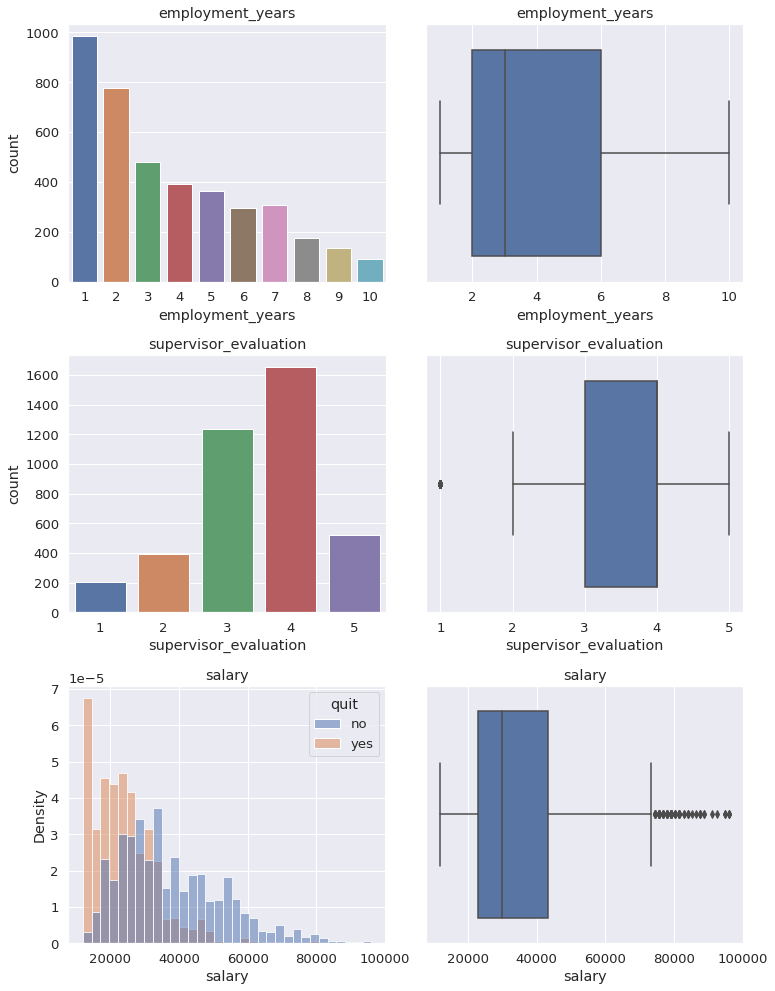

In [39]:
numbers_plot(train_quit, 'quit')

Обработаем выбросы

In [40]:
before = len(train_quit)
train_quit = train_quit[train_quit['supervisor_evaluation'] > 1]

In [41]:
train_quit = train_quit[train_quit['salary'] < 73000]
after = len(train_quit)

In [42]:
(before - after) * 100 / before

7.225

В итоге мы избавились от 289 значений. Около 7% данных нам пришлось удалить, т.к. они оказались выбросами.

Теперь посмотрим на категориальные данные

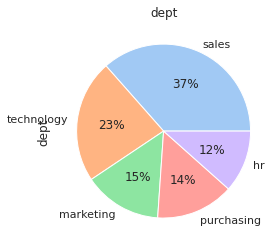

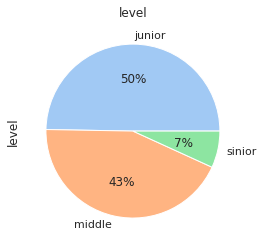

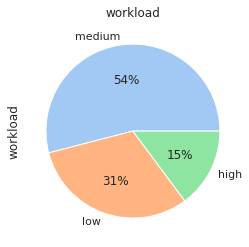

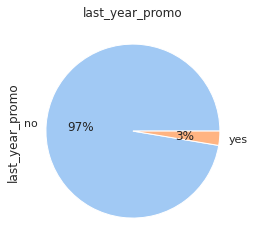

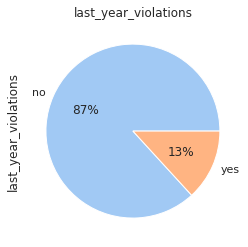

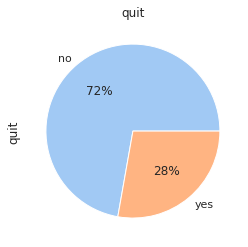

In [43]:
kat_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
kategory_col(train_quit, kat_col)

В dept больше всего работников sales. По уровню работы джунов чуть больше мидлов, а сеньеров значительно меньше. Большая часть работников имеет среднее кол-во часов работы. Очень мало человек, которых повышали по должности за последний год. Работники, которые нарушали правила трудового договора 13%. И тут добавился новый признак quit. В нем треть хочет уволиться, а остальных все устраивает

Теперь посмотрим на тестовые данные. Тут у нас нет целевого признака, поэтому делаем параметр last_year_promo

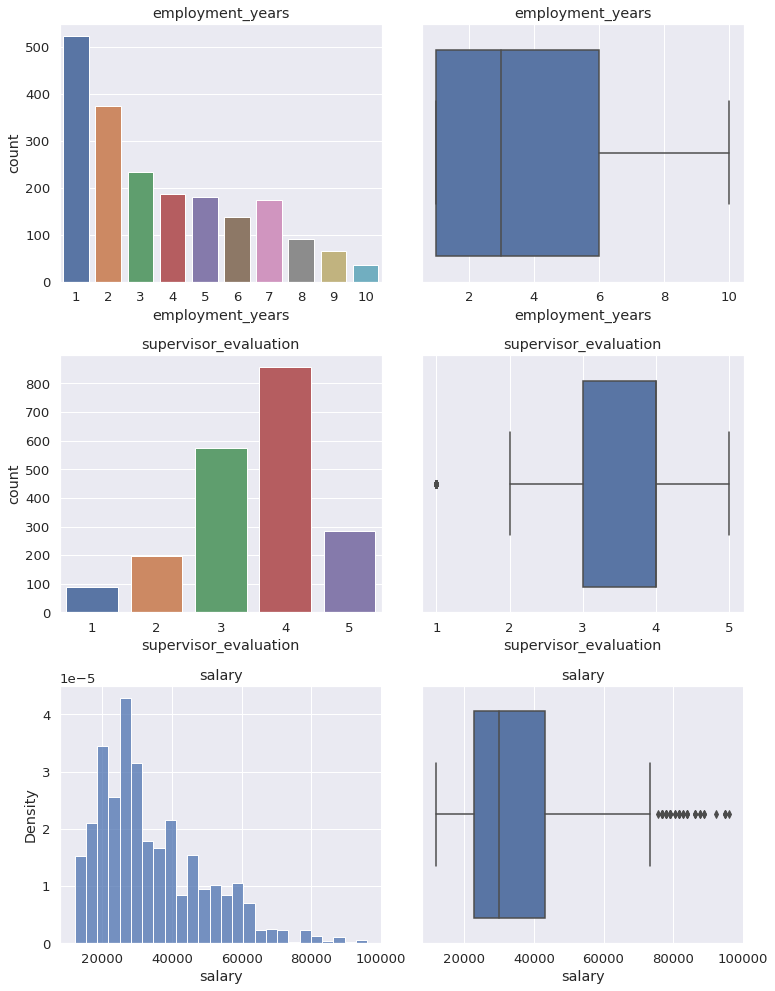

In [44]:
numbers_plot(test_features, param_hue=None)

Тут нельзя удалять выбросы. Пусть живут

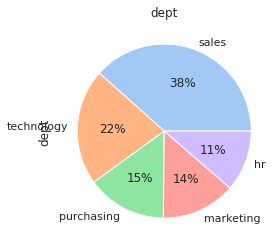

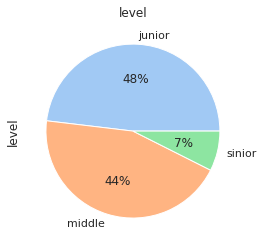

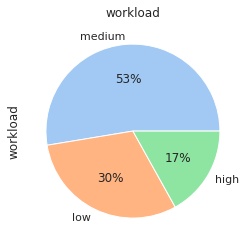

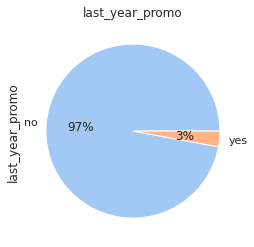

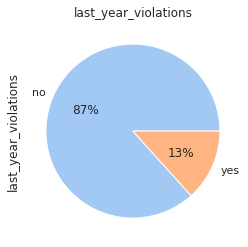

In [45]:
kat_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
kategory_col(train_job_satisfaction_rate, kat_col)

В dept больше всего работников sales. По уровню работы джунов чуть больше мидлов, а сеньеров значительно меньше. Большая часть работников имеет среднее кол-во часов работы. Очень мало человек, которых повышали по должности за последний год. Работники, которые нарушали правила трудового договора 13%

Посмотрим на корреляции всех наших признаков

In [46]:
test_features.drop(['id'], axis=1).phik_matrix(interval_cols=['salary'])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
dept,1.000000,0.000000,0.033894,0.000000,0.000000,0.000000,0.060917,0.309803
level,0.000000,1.000000,0.474151,0.689666,0.118258,0.017527,0.000000,0.740796
workload,0.033894,0.474151,1.000000,0.202240,0.035609,0.000000,0.036353,0.778903
employment_years,0.000000,0.689666,0.202240,1.000000,0.173637,0.066371,0.000000,0.497227
last_year_promo,0.000000,0.118258,0.035609,0.173637,1.000000,0.000000,0.011704,0.193125
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.059217
supervisor_evaluation,0.060917,0.000000,0.036353,0.000000,0.011704,0.189719,1.000000,0.039832
salary,0.309803,0.740796,0.778903,0.497227,0.193125,0.059217,0.039832,1.000000


Проанализирем сначала последнюю строку, т.к. job_satisfaction_rate это целевой признак. employment_years last_year_promo last_year_violations supervisor_evaluation данные столбцы показали неплохую корреляцию, начиная с 0.33 и заканчивая 0.77. Эти признаки будут оказывать большее влияние на итоговую метрику.
Посмотрим на входные признаки:
* dept. Сильно не коррелирует с остальными признаками, поэтому мультиколлинеарности не вызывает.
* level. Есть достаточно большая связь с двумя очень важными employment_years и salary около 0.67. Этого не должно хватить для создания мультиколлинеарности, но все же возьмем на заметку, т.к. с целевым признаком особой взаимосвязи у него нет(около 0.2)
* workload. Достаточно сильно коррелирует с salary с показателем 0.74, а с job_satisfaction_rate - нет, всего 0.16. Тоже стоит запомнить
* employment_years. Про него уже есть вся информация выше.
* last_year_promo. Ни с кем их входных признаком сильно не связан.
* last_year_violations. Такая же ситуация, как и с last_year_promo
* supervisor_evaluation. Тоже ни с кем не сильно не связан, кроме целевого признака.
* salary. Есть связь с level(0.67) и с workload(0.74). Это достаточно высокие показатели. 
* А с job_satisfaction_rate корреляция всего - 0.12, поэтому можно будет попробовать удалить этот признак.

На данном шаге мы провели достаточно объемный исследовательский анализ данных. Сделали оптимизацию входных признаков, поменяли некоторые типы данных на bool, в том числе и у целевого рпизнака, удалили выбросы, заменили неявные дубликаты в виде пробела на пропуски. Построили графики с выделением целевого признака, как таргет. Сильных зависимостей между входными признаками нет, а значит и нет мультиколлинеарности

### Портрет "уволившегося сотрудника"

Необходимую информацию можно получить из анализа данных, где мы строили гистограммы для тренировочных данных, в которых есть зависимость от целевого признака. Желтым выделены сотрудники, которые уволятся

Давайте выделим нужную нам информацию из трех графиков  
- Длительность работы в компании у тех, кто уволится, в основном составляет от 1 до 3 лет. Чем меньше, тем чаще это происходит
- Немаловажно влияние оценки качества работы сотрудника, которую дал руководитель, ведь большая доля, которой поставили оценку 2 или 3(1 не считаем, т.к. это оказались выбросы) увольняются
- Ну и зарплата. Основная часть увольняющихся сотрудников сосредоточена в самом начале, то есть у тех, кто меньше всего зарабатывает, что достаточно логично. Это до 35000.

Но помимо этих трех есть еще и другие признаки. Из них тоже нужно получить информацию. Для этого создадим таблицу только с теми, у кого в тестовой выборке quit = 1

In [47]:
quit_true = train_quit[train_quit['quit'] == 'yes']
quit_true

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes
...,...,...,...,...,...,...,...,...,...,...
3989,150315,purchasing,junior,low,1,no,no,2,15600,yes
3991,778735,technology,junior,low,2,no,no,4,22800,yes
3994,775320,technology,junior,high,1,no,no,4,42000,yes
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes


Таких людей достаточно много. Это хорошо

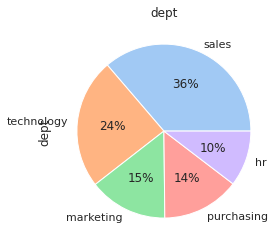

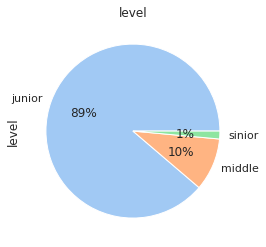

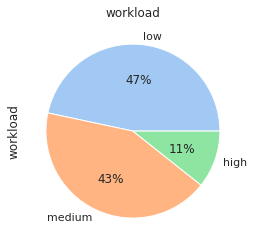

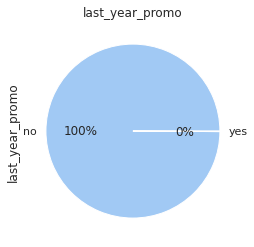

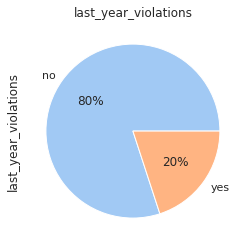

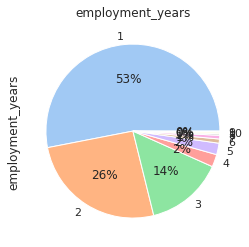

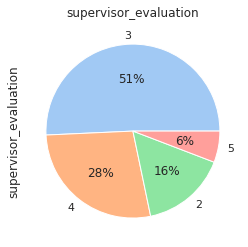

In [48]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'employment_years', 'supervisor_evaluation']
kategory_col(quit_true, columns)

По всем данным можно составить портрет уволившегося сотрудника. Это junior, работающий около одного года, со слабой или средней загруженностью, из отдела technology или sales, которому работодатель поставил низкую оценку качества работы (2 или 3). Его зарплата меньше 35000, последний год он не получал повышения.

### Проверка влияния job_satisfaction_rate на новый целевой признак

Из первой задачи у нас был целевой признак job_satisfaction_rate, который показывал удовлетворенность сотрудника работой в компании. Почему бы и не добавить еще один признак? Главное, чтобы он имел хоть какое-то влияние на нащ новый целевой признак. Проверим это на целевых признаках тестовых выборок

In [49]:
test_target_job_satisfaction_rate

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69
...,...
997290,0.79
998548,0.76
998762,0.48


In [50]:
# Сразу сделаем столбец id индексами
test_target_quit = test_target_quit.set_index('id')
test_target_quit

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no
...,...
997290,no
998548,yes
998762,yes


Столбцы у нас уже отсортированы, кол-во строк совпадает, поэтому можно объдинять

In [51]:
target_job_guit = test_target_job_satisfaction_rate.merge(test_target_quit, left_index=True, right_index=True, how='outer')
target_job_guit

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no
...,...,...
997290,0.79,no
998548,0.76,yes
998762,0.48,yes


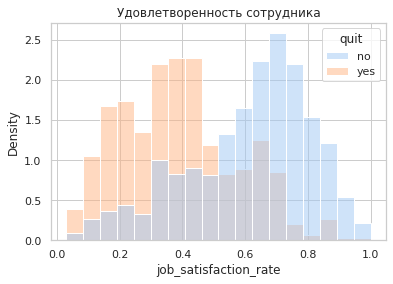

In [52]:
sns.histplot(data = target_job_guit, x = 'job_satisfaction_rate', hue = 'quit', stat='density', common_norm=False)
plt.title('Удовлетворенность сотрудника')
plt.show()

Чем меньше удовлетворены сотрудники, тем чаще они увольняются. Это логично, поэтому зависимость между двумя признаками есть есть.

Подведем итоги всего шага исследовательского анализа данных. С помощью трех функций оптимизировали количественные данные, удалили около 7% пропусков.  
Составили портрет «уволившегося сотрудника» с помощью гистограммы, на которой выделили таргет увольняющихся сотрудников по целевому признаку. У нас получился такой портрет: junior, работающий около одного года, со слабой или средней загруженностью, из отдела technology или sales, которому работодатель поставил низкую оценку качества работы (2 или 3). Его зарплата меньше 35000, последний год он не получал повышения.  
Была проведена проверка связи между целевыми признаками в первой и второй задачах. Оказалось, что job_satisfaction_rate влияет на quit, поэтому его можно будет добавить ко всем входным признакам.

## Добавление нового признака

Так как признаки оказались связаны, то было принято решение добавить job_satisfaction_rate ко всем входным данным. Это нужно сделать как для тренировочных данных, так и для тестовых. И в этом нам поможет модель, которую мы создали при решении первой задачи. Не забываем, что у нас supervisor_evaluation должен быть преобразован в бинарный признак, но как оказалось, это преобразование делает нашу метрику хуже на 0.01, поэтому будем использовать randomized_search_1 из первой модели первого задания

In [54]:
train_quit.reset_index(drop=True, inplace=True)
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,257132,sales,junior,medium,2,no,yes,3,24000,yes
3,910140,marketing,junior,medium,2,no,no,5,25200,no
4,699916,sales,junior,low,1,no,yes,3,18000,yes
...,...,...,...,...,...,...,...,...,...,...
3706,588809,sales,junior,medium,4,no,no,3,26400,no
3707,672059,sales,middle,high,9,no,no,4,52800,no
3708,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3709,692133,purchasing,middle,medium,2,no,no,4,33600,no


In [55]:
pred = randomized_search_1.predict(train_quit.drop(['id', 'quit'], axis = 1))
len(pred)

3711

In [56]:
pred = pd.DataFrame(data = pred)
pred.columns = ['job_satisfaction_rate']
pred

,job_satisfaction_rate
0,0.657619
1,0.815938
2,0.380000
3,0.690000
4,0.180000
...,...
3706,0.533333
3707,0.846842
3708,0.560000
3709,0.515714


Вот теперь можно объединять наши таблички

In [57]:
train_quit_new = train_quit.merge(pred, left_index=True, right_index=True, how='outer')
train_quit_new

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.657619
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
2,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
3,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000
4,699916,sales,junior,low,1,no,yes,3,18000,yes,0.180000
...,...,...,...,...,...,...,...,...,...,...,...
3706,588809,sales,junior,medium,4,no,no,3,26400,no,0.533333
3707,672059,sales,middle,high,9,no,no,4,52800,no,0.846842
3708,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.560000
3709,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.515714


Красота!

тоже самое нужно сделать теперь с тестовыми данными

In [58]:
test_features.reset_index(drop=True, inplace=True)
pred = randomized_search_1.predict(test_features.drop(['id'], axis = 1))
pred = pd.DataFrame(data = pred)
pred.columns = ['job_satisfaction_rate']
test_features_new = test_features.merge(pred, left_index=True, right_index=True, how='outer')
test_features_new

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.835185
1,100480,marketing,junior,low,4,no,no,4,16800,0.850000
2,100503,purchasing,middle,high,5,no,no,4,55200,0.738000
3,100610,sales,middle,medium,5,no,no,4,43200,0.824127
4,100692,sales,middle,high,6,no,no,4,48000,0.679583
...,...,...,...,...,...,...,...,...,...,...
1995,997290,sales,sinior,medium,7,no,no,4,58800,0.845385
1996,998548,marketing,junior,medium,2,no,no,4,32400,0.790000
1997,998762,technology,junior,low,3,no,no,3,22800,0.497500
1998,998900,marketing,middle,medium,7,no,no,3,45600,0.438400


Good job!

Мы добавили к нашим исходным данным в тренировочную и тестовую выборки еще один признак, который предсказала наша модель

## Создание пайплайна

После добавления нового признака нужно проверить мультиколлинеарность

In [59]:
train_quit_new.drop(['id'], axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
dept,1.000000,0.018263,0.000000,0.000000,0.000000,0.031576,0.022390,0.267228,0.000000,0.214295
level,0.018263,1.000000,0.428599,0.689849,0.103123,0.000000,0.000000,0.675556,0.299624,0.139587
workload,0.000000,0.428599,1.000000,0.185488,0.028145,0.019867,0.000000,0.755980,0.125176,0.151098
employment_years,0.000000,0.689849,0.185488,1.000000,0.159341,0.000000,0.000000,0.471449,0.643651,0.404409
last_year_promo,0.000000,0.103123,0.028145,0.159341,1.000000,0.007389,0.033311,0.173669,0.148875,0.322727
last_year_violations,0.031576,0.000000,0.019867,0.000000,0.007389,1.000000,0.326030,0.050005,0.190756,0.573548
supervisor_evaluation,0.022390,0.000000,0.000000,0.000000,0.033311,0.326030,1.000000,0.045801,0.446544,0.695744
salary,0.267228,0.675556,0.755980,0.471449,0.173669,0.050005,0.045801,1.000000,0.532560,0.207729
quit,0.000000,0.299624,0.125176,0.643651,0.148875,0.190756,0.446544,0.532560,1.000000,0.527539
job_satisfaction_rate,0.214295,0.139587,0.151098,0.404409,0.322727,0.573548,0.695744,0.207729,0.527539,1.000000


Заметим, что тут есть высокая корреляция среди 'supervisor_evaluation' и 'job_satisfaction_rate'. Попробуем убрать 'supervisor_evaluation'. Спойлер: попробовал, не помогло.  
Приступим к созданию пайплайна

In [60]:
# Для начала переведем во всех таблицах id в индексы
train_quit_new = train_quit_new.set_index('id')
test_features_new = test_features_new.set_index('id')
# Проверим дубликаты
train_quit_new.duplicated().sum()

1381

In [61]:
# Удалим дубликаты
train_quit_new.drop_duplicates()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.657619
814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000
699916,sales,junior,low,1,no,yes,3,18000,yes,0.180000
...,...,...,...,...,...,...,...,...,...,...
778735,technology,junior,low,2,no,no,4,22800,yes,0.844000
106936,marketing,junior,low,1,no,no,5,18000,no,0.860000
775320,technology,junior,high,1,no,no,4,42000,yes,0.540000


In [62]:
# Записываем постоянные
RANDOM_STATE = 42
TEST_SIZE = 0.25
# Делим выборки
X_train = train_quit_new.drop(['quit'], axis = 1)
y_train = train_quit_new['quit']
X_test = test_features_new
y_test = test_target_quit
y_test = pd.Series(y_test['quit'], name='quit')

In [63]:
# Проверка
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)
# Столбцы для кодирований
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation', 'employment_years']
num_columns = ['salary']


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Подготовка признаков
# Пропуски есть только в столбцах dept и level. Они находятся в OHE и OE
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ohe', OneHotEncoder(drop = 'first'))]
)

# SimpleImputer + OE
ord_pipe = Pipeline(
        [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories = [['junior', 'middle', 'sinior'], ['medium', 'low', 'high'],[1, 2, 3, 4, 5],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],], 
                handle_unknown = 'use_encoded_value', unknown_value = np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# Делаем общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Модель + подготовка данных
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
        # Модель DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20), # глубина дерева
        'models__max_leaf_nodes': range(1, 50), # отвечает за ограничение кол-ва листьев
        'models__min_samples_split': range(2, 40), # сколько значений должно быть для того, чтобы узел м.б. разделить
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
         # Модель KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10), # кол-во соседей
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

         # Модель LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l1', max_iter=1000)], # тк есть l1, то добавить нужно solver='saga'
        'models__C': np.arange(0.1, 5, 0.5), # перебирает сложность модели от слабой до сильной
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
        # Модель SVC
    {
        'models' : [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel' : ['linear', 'rbf', 'sigmoid', 'poly'],
        'models__degree' : range(1, 5), 
        'models__C' : np.arange(0.1, 5, 0.5),
        #'models__gamma' : np.arange(0.1, 2, 0.5), #с этим параметром перебор становится невероятно долгим
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# RandomizedSearchCV: инициализация и обучение 
randomized_search = RandomizedSearchCV( 
 pipe_final,  
 param_grid,  
 cv=5, 
 scoring = 'roc_auc', 
 random_state=RANDOM_STATE, 
 n_jobs=-1,  
)

randomized_search.fit(X_train, y_train_encoded) 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)  
print('Лучшее значение метрики ROC_AUC на тренировочной выборке :\n\n', randomized_search.best_score_) 
print('Лучшие параметры модели :\n\n', randomized_search.best_params_)

(3711, 9)

(3711,)

(2000, 9)

(2000,)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent...
                                 

Получилась метрика ROC_AUC = 0.93. Это отличный результат. Для этого пришлось подобрать достаточно глубокие гиперпараметры у дерева решений, но это сделало метрику на тестовых данных еще лучше. Еще понадобилось удалить дубликаты после переноса id в индексы

In [64]:
pred = randomized_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, pred)
print(f"ROC AUC на тестовой выборке: {roc_auc}")

ROC AUC на тестовой выборке: 0.9256109366048322


Дерево решений оказалось лучшей моделью, так как может обнаруживать сложные нелинейные связи между признаками, большим кол-ом гиперпараметров, перебор которых помогает найти идеально подходящую модель.

## Вывод

В данном проекте мы помогли достаточно крупной компании "Работа с заботой" по предоставленным данным оптимизировать управление персоналом, чтобы избежать финансовых потерь и оттока сотрудников. У нас было несколько задач. Первая задача заключалась в построении модели, способной предсказать уровень удовлетворённости сотрудника на основе предоставленных данных. Для этого нам были предоставлены файлы с данными: тренировочная выборка, входные признаки тестовой выборки, и целевой признак тестовой выборки. Удовлетворённость работой напрямую влияет на отток сотрудников, поэтому предсказание уровня удовлетворённости является важной задачей для компании. 
Вторая задача заключалась в построении модели, способной на основе предоставленных данных предсказать, уволится ли сотрудник или останется в компании. Для этой задачи были предоставлены похожие файлы, только уже с другим целевым признаком  
Задачи пришлось разделить на шаги. Начнем с первой - модель, которая предсказывает уровень удовлетворенности сотрудников.  
- **Загрузка данных.** Этот этап включал в себя корректное считывание и поверхностный анализ данных, предоставленных компанией. Проблем никаких не возникло
- **Предобработка данных.** На данном шаге мы изменили типы данных у большинства столбцов для удобства и быстроты работы. Сравнили тренировочные и тестовые выборки, проверили пропуски и дубликаты(явные и неявные). Пропуски решили исправить при создании пайплайна, а из дубликатов оказались только неявные(пробелы вместо некоторых пропусков). Все это было исправлено
- **Исследовательский анализ данных.** В нем мы отобразили с помощью гистограмм, ящиков с усами и столбчатых диаграмм все признаки, которые нам предоставила компания. Было удалено около чуть меньше 7% данных
- **Корреляционный анализ.** Между входными признаками мультиколлинеарности не было замечено. Бошльше всех выделялся признак оценки качества работы, из-за высокой корреляции и не совсем линейной зависимости. Пришлось проверить модель с переводом столбца supervisor_evaluation в категориальный признак, что в будущем помогло улучшить модель
- **Создание пайплайна.** На данном шаге мы создали пайплайн, который кодирует категориальные признаки с помощью двух кодировщиков: OneHotEncoder и OrdinalEncoder, а числовые - StandardScaler(), MinMaxScaler. Категориальные признаки еще предобрабатываются с помощью SimpleImputer, который заполняет пропуски популярными значениями. В пайплайне есть три модели с различными параметрами: DecisionTreeRegressor, LinearRegression, KNeighborsClassifier. С помощью RandomizedSearchCV перебираются модели и из них выбирается лучшая. Это оказалась модель DecisionTreeRegressor(random_state=42) с такими параметрами: 'preprocessor__num': MinMaxScaler(), 'models__max_depth': 15. Метрика на тренировочной выборке SMAPE - 14.3, а на тестовой - 14.48. Результат оказался очень хорошим.

Шаги выполнения второй задачи.  
- **Загрузка данных.** Данный этап, как и при решений первой задачи оказался простым. Просто загрузили данные без изменений.
- **Предобработка данных.** Мы изменили типы данных у большинства столбцов для удобства и быстроты работы. Сравнили тренировочные и тестовые выборки, проверили пропуски и дубликаты(явные и неявные). Пропуски решили исправить потом в пайплайне, а из дубликатов оказались только неявные(пробелы вместо некоторых пропусков). Все это было исправлено.
- **Исследовательский анализ данных.** Он состоял из трех подпунктов: проведение исследовательского анализа данных, создание портрета уволившегося сотрудника и проверка утверждения, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. В анализе данных с помощью их визуализации удалили выбросы, увидели различные зависимости признаков. Получили портрет уволившегося сотрудника. Это junior, работающий около одного года, со слабой или средней загруженностью, из отдела technology или sales, которому работодатель поставил низкую оценку качества работы (2 или 3). Его зарплата меньше 35000, последний год он не получал повышения. Проведели проверку связи между целевыми признаками в первой и второй задачах. Оказалось, что job_satisfaction_rate влияет на quit, поэтому его решили добавить ко всем входным признакам.
- **Добавление нового входного признака.** Присоединили к нашим исходным данным в тренировочную и тестовую выборки еще один признак, который предсказала наша первая модель.
- **Создание пайплайна.** На данном шаге мы обучили 4 различных модели для решения поставленной бинарной задачи. Включили по два различных метода обработки категориальных и числовых признаков. И с помощью randomized_search нашли лучшую модель с найбольшей метрикой roc_auc на тестовой выборке. Этого нам показалось мало, поэтому мы решили улучшить модель с помощью создания новой метрики влияния зарплаты на удовлетворенность сотрудника, что приятно улучшило результат. Лучшей моделью снова оказалось дерево решений с возможной при учете погрешностей метрикой roc_auc = 0.91.

Для уменьшения кол-ва увольнений, компании "Работа с заботой" можно посоветовать увеличить зарплату, но это может быть не так прибыльно, поэтому нужно повысить уровень удовлетворённости сотрудника работой в компании, так как от этого признака больше всего зависит будущее сотрудника. Это можно сделать с помощью увеличения длительности работы сотрудников. Их нужно как-то заманивать оставаться подольше в компании, чем дольше человек находится в компании, тем вероятнее, что он останется подольше. Еще можно чаще повышать своих сотрудников. Данные признаки неплохо связаны с job_satisfaction_rate, а сам признак с целевым quit. 